
# Machine Learning on Iris Dataset Part 2: Unsupervised Machine Learning Using Python

In my previous blogpost, I used supervised machine learning to classify the variety of Iris flower. The prediction was based on shape of an iris leaf represented by its sepal length, sepal width, petal length and petal width as shown in the image. However mush such classification problems come without labels and unsupervised machine learning is required to find clusters in the data, based on the features. 

![Iris](./iris.png)


## Understanding and loading the data

I used the dataset from the [DataQuest website](https://www.dataquest.io/m/51/introduction-to-neural-networks) that only contains two species of iris.
The data set consists of:
* **110 samples** 
* **2 labels: species of Iris (Iris virginica_ and _Iris versicolor_)** 
* **4 features: length and the width of the sepals and petals**, in centimetres.



In [2]:
# install relevant modules
import numpy as np
import pandas as pd

# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

import seaborn as sns
sns.set(style="white", color_codes=True)

In [3]:
# Read in dataset
iris = pd.read_csv("iris.csv")
# shuffle rows
shuffled_rows = np.random.permutation(iris.index)
iris = iris.loc[shuffled_rows,:]
print(iris.head())

    sepal_length  sepal_width  petal_length  petal_width          species
27           6.7          3.0           5.0          1.7  Iris-versicolor
39           5.5          2.5           4.0          1.3  Iris-versicolor
90           6.7          3.1           5.6          2.4   Iris-virginica
22           6.3          2.5           4.9          1.5  Iris-versicolor
26           6.8          2.8           4.8          1.4  Iris-versicolor


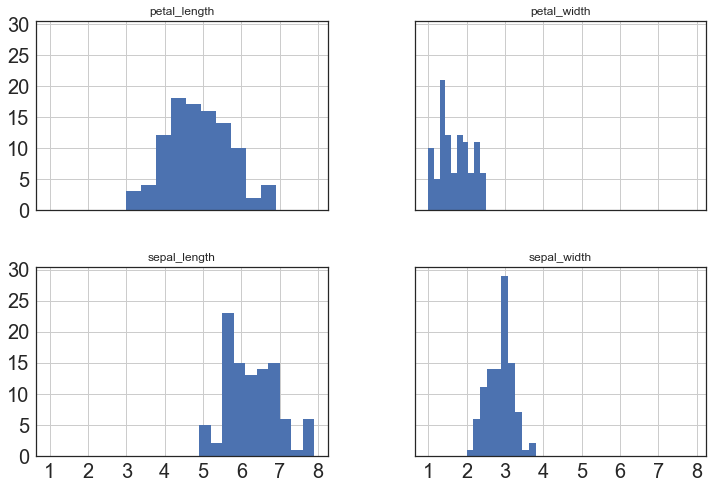

In [4]:
iris.hist(sharey=True, sharex=True, figsize=(12,8), ylabelsize=20, xlabelsize=20)
plt.show()

Its clear from the histograms above that the petal length has the largest variability as opposed to the sepal width which seems to have a much smaller variance.

## Neural Networks

### Define a Neuron

Neural networks are very loosely inspired by the structure of neurons in the human brain. These models are built by using a series of activation units, known as neurons, to make predictions of some outcome. Neurons take in some input, apply a transformation function, and return an output. In the following code cell, we 

1. Write a function called sigmoid_activation with inputs 'x' a feature vector and 'theta' a parameter vector of the same length to implement the sigmoid activation function.

$$ h_\theta = \frac{1}{1+e^{-\theta^T X}}$$

2. Assign the value of sigmoid_activation(x0, theta_init) to a1. a1 should be a vector

In [6]:
# Variables to test sigmoid_activation
iris["ones"] = np.ones(iris.shape[0])
X = iris[['ones', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = (iris.species == 'Iris-versicolor').values.astype(int)

# The first observation
x0 = X[0]

# Initialize thetas randomly 
theta_init = np.random.normal(0,0.01,size=(5,1))

print(x0, theta_init)

def sigmoid_activation(x, theta):
    sigmoid = 1 / (1 + np.exp(-np.dot(theta.T, x)))
    return(sigmoid)

a1 = sigmoid_activation(x0, theta_init)
print(a1)


[ 1.   6.7  3.   5.   1.7] [[ 0.00349182]
 [-0.00304811]
 [-0.00298177]
 [-0.02291648]
 [-0.01017867]]
[ 0.46064112]


### Cost function

We can train a single neuron as a two layer network using gradient descent. We need to minimize a cost function which measures the error in our model. The cost function measures the difference between the desired output and actual output.

- We first write a function, single_cost(), that can compute the cost from just a single observation.
 $$ J_\theta = - y \log h - (1-y) log (1-h)$$
 
- This function should use input features X, targets y, and parameters theta to compute the cost function.
- Assign the cost of variables x0, y0, and theta_init to variable first_cost.


In [7]:
# First observation's features and target
x0 = X[0]
y0 = y[0]

# Initialize parameters, we have 5 units and just 1 layer
theta_init = np.random.normal(0,0.01,size=(5,1))

# This function should use input features X, targets y, 
# and parameters theta to compute the cost function.
def single_cost(x, y, theta):
    h = sigmoid_activation(x.T, theta)
    cost = -np.mean(y * np.log(h) + (1-y) * np.log(1-h))
    return(cost)

first_cost = single_cost(x0, y0, theta_init)
print(first_cost)

0.699366335358


### Compute the Gradients

Calculating derivatives are more complicated in neural networks than in linear regression. Here we compute the overall error and then distribute that error to each parameter. 
For single layer, we use the quardratic cost function for error estimates:

$$ J_\theta = -\frac{1}{2} (y-h)^2 \to \frac{\partial J_\theta}{\partial h} = y-h$$

and the derivative of the logit function is given by:

$$\frac{\partial h}{\partial \theta} = h(1-h)X$$

hence by using chain rule, 

$$\frac{\partial J_\theta}{\partial \theta}  = (y-h) h (1-h) X$$


In the following code we:

- Compute the average gradients over each observation in X and corresponding target y with the initialized parameters theta_init.
- Assign the average gradients to variable grads


In [10]:
## Compute the Gradients ##

# Initialize parameters
theta_init = np.random.normal(0,0.01,size=(5,1))

# Store the updates into this array
grads = np.zeros(theta_init.shape)

# Number of observations 
n = X.shape[0]

for j, obs in enumerate(X):
    h = sigmoid_activation(obs, theta_init)
    delta = (y[j]-h) * h * (1-h) * obs
    grads += delta[:,np.newaxis]/X.shape[0]

print(grads)

[[ 0.00623501]
 [-0.0010689 ]
 [ 0.00536612]
 [-0.04922254]
 [-0.03284114]]


### Gradient Descent

Now that we can compute the gradients, we use gradient descent to learn the parameters and predict the species of iris flower given the 4 features. Gradient descent minimizes the cost function by adjusting the parameters accordingly. We adjust the parameters by substracting the product of the gradients and the learning rate from the previous parameters. Finally, we repeat until the cost function coverges or a maximum number of iterations is reached.

#### Pseudo-Code

```python
while (number_of_iterations < max_iterations 
    and (prev_cost - cost) > convergence_thres ):
    update paramaters
    get new cost
    repeat
```

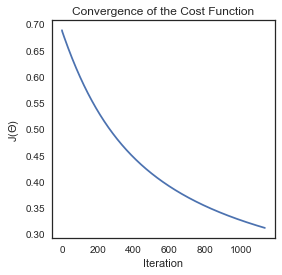

In [18]:
## Gradient descent ##
theta_init = np.random.normal(0,0.01,size=(5,1))

# set a learning rate
learning_rate = 0.1

# maximum number of iterations for gradient descent
maxepochs = 10000     

# costs convergence threshold, ie. (prevcost - cost) > convergence_thres
convergence_thres = 0.0001  

def learn(X, y, theta, learning_rate, maxepochs, convergence_thres):
    costs = []
    cost = single_cost(X, y, theta)  # compute initial cost
    costprev = cost + convergence_thres + 0.01  # set an inital costprev to past while loop
    counter = 0  # add a counter
    # Loop through until convergence
    for counter in range(maxepochs):
        grads = np.zeros(theta.shape)
        for j, obs in enumerate(X):
            h = sigmoid_activation(obs, theta)   # Compute activation
            delta = (y[j]-h) * h * (1-h) * obs   # Get delta
            grads += delta[:,np.newaxis]/X.shape[0]  # accumulate
        
        # update parameters 
        theta += grads * learning_rate
        counter += 1  # count
        costprev = cost  # store prev cost
        cost = single_cost(X, y, theta) # compute new cost
        costs.append(cost)
        if np.abs(costprev-cost) < convergence_thres:
            break
        
    plt.figure(figsize=(4,4))
    plt.plot(costs) 
    plt.title("Convergence of the Cost Function")
    plt.ylabel("J($\Theta$)")
    plt.xlabel("Iteration")
    plt.show()
    return theta
        
theta = learn(X, y, theta_init, learning_rate, maxepochs, convergence_thres)

## 2-layer Network
Neural networks are usually built using mulitple layers of neurons. Adding more layers into the network allows to learn more complex functions.

### Feed Forward

Here we are organizing multiple logistic regression models to create a more complex function.
- Write a function feedforward() that will take in an input X and two sets of parameters theta0 and theta1 to compute the output hΘ(X).
- Assign the output to variable h using features X and parameters theta0_init and theta1_init

In [23]:
# two layer neural nets

theta0_init = np.random.normal(0,0.01,size=(5,4))
theta1_init = np.random.normal(0,0.01,size=(5,1))

def feedforward(X, theta0, theta1):
    # feedforward to the first layer
    a1 = sigmoid_activation(X.T, theta0).T
    
    # add a column of ones for bias term
    a1 = np.column_stack([np.ones(a1.shape[0]), a1])
    
    # activation units are then input to the output layer
    out = sigmoid_activation(a1.T, theta1)
    return out

h = feedforward(X, theta0_init, theta1_init)

#print(h)

### Multiple neural network cost function

The cost function to multiple layer neural networks is identical to the cost function we used for two networks, but hΘ(x) is more complicated.

In [24]:
## Multiple neural network cost function ##

theta0_init = np.random.normal(0,0.01,size=(5,4))
theta1_init = np.random.normal(0,0.01,size=(5,1))

# X and y are in memory and should be used as inputs to multiplecost()

def multiplecost(X, y, theta0, theta1):
    # feed through network
    h = feedforward(X, theta0, theta1) 
    
    # compute error
    inner = y * np.log(h) + (1-y) * np.log(1-h)
    
    # negative of average error
    return -np.mean(inner)

c = multiplecost(X, y, theta0_init, theta1_init)
print(c)


0.693138482897


## Multiple-layer Network and Backpropagation

Backpropagation focuses on updating parameters starting at the last layer and circling back through each layer, updating accordingly. We have reused feedforward() and multiplecost() but in more condensed forms. During initialization, we set attributes like the learning rate, maximum number of iterations to convergence, and number of units in the hidden layer. In learn() we have the backpropagation algorithm, which computes the gradients and updates the parameters. We then test the class by using the features and the species of the flower.

In [25]:
# Use a class for this model
class NNet3:
    def __init__(self, learning_rate=0.5, maxepochs=1e4, convergence_thres=1e-5, hidden_layer=4):
        self.learning_rate = learning_rate
        self.maxepochs = int(maxepochs)
        self.convergence_thres = 1e-5
        self.hidden_layer = int(hidden_layer)
        
    def _multiplecost(self, X, y):
        # feed through network
        l1, l2 = self._feedforward(X) 
        # compute error
        inner = y * np.log(l2) + (1-y) * np.log(1-l2)
        # negative of average error
        return -np.mean(inner)
    
    def _feedforward(self, X):
        # feedforward to the first layer
        l1 = sigmoid_activation(X.T, self.theta0).T
        # add a column of ones for bias term
        l1 = np.column_stack([np.ones(l1.shape[0]), l1])
        # activation units are then inputted to the output layer
        l2 = sigmoid_activation(l1.T, self.theta1)
        return l1, l2
    
    def predict(self, X):
        _, y = self._feedforward(X)
        return y
    
    def learn(self, X, y):
        nobs, ncols = X.shape
        self.theta0 = np.random.normal(0,0.01,size=(ncols,self.hidden_layer))
        self.theta1 = np.random.normal(0,0.01,size=(self.hidden_layer+1,1))
        
        self.costs = []
        cost = self._multiplecost(X, y)
        self.costs.append(cost)
        costprev = cost + self.convergence_thres+1  # set an inital costprev to past while loop
        counter = 0  # intialize a counter

        # Loop through until convergence
        for counter in range(self.maxepochs):
            # feedforward through network
            l1, l2 = self._feedforward(X)

            # Start Backpropagation
            # Compute gradients
            l2_delta = (y-l2) * l2 * (1-l2)
            l1_delta = l2_delta.T.dot(self.theta1.T) * l1 * (1-l1)

            # Update parameters by averaging gradients and multiplying by the learning rate
            self.theta1 += l1.T.dot(l2_delta.T) / nobs * self.learning_rate
            self.theta0 += X.T.dot(l1_delta)[:,1:] / nobs * self.learning_rate
            
            # Store costs and check for convergence
            counter += 1  # Count
            costprev = cost  # Store prev cost
            cost = self._multiplecost(X, y)  # get next cost
            self.costs.append(cost)
            if np.abs(costprev-cost) < self.convergence_thres and counter > 500:
                break


### Set a Learning Rate

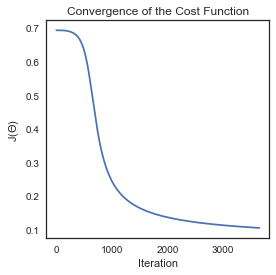

In [27]:
# Set a learning rate
learning_rate = 0.5
# Maximum number of iterations for gradient descent
maxepochs = 10000       
# Costs convergence threshold, ie. (prevcost - cost) > convergence_thres
convergence_thres = 0.00001  
# Number of hidden units
hidden_units = 4

# Initialize model 
model = NNet3(learning_rate=learning_rate, maxepochs=maxepochs,
              convergence_thres=convergence_thres, hidden_layer=hidden_units)
# Train model
model.learn(X, y)

# Plot costs
plt.figure(figsize=(4,4))
plt.plot(model.costs)
plt.title("Convergence of the Cost Function")
plt.ylabel("J($\Theta$)")
plt.xlabel("Iteration")
plt.show()

## Train a Model

Now that we have learned about neural networks, learned about backpropagation, and have code which will train a 3-layer neural network, we will split the data into training and test datasets and run the model.

### Test-Train Split

In [28]:
# First 70 rows to X_train and y_train
# Last 30 rows to X_train and y_train

X_train = X[:70]
y_train = y[:70]

X_test = X[-30:]
y_test = y[-30:]

#print(X_train, y_train, X_test, y_test)

## Make predictions

To benchmark how well a three layer neural network performs when predicting the species of iris flowers, we compute the AUC, area under the curve, score of the receiver operating characteristic. 

The function NNet3 not only trains the model but also returns the predictions. The method predict() will return a 2D matrix of probabilities. Since there is only one target variable in this neural network, we select the first row of this matrix, which corresponds to the type of flower.

In [32]:
## Predicting iris flowers ##

from sklearn.metrics import roc_auc_score
# Set a learning rate
learning_rate = 0.5
# Maximum number of iterations for gradient descent
maxepochs = 10000       
# Costs convergence threshold, ie. (prevcost - cost) > convergence_thres
convergence_thres = 0.00001  
# Number of hidden units
hidden_units = 4

# Initialize model 
model = NNet3(learning_rate=learning_rate, maxepochs=maxepochs,
              convergence_thres=convergence_thres, hidden_layer=hidden_units)

model.learn(X_train, y_train)

yhat = model.predict(X_test)[0]
auc = roc_auc_score(y_test, yhat)
print(auc)

0.99043062201
